# VR Sample Dependence

For Calo jets, many people are mostly interested in the low $p_T$ performance, so we have this hybrid definition that allows us to provide good performance over a broad $p_T$ range. However, for VR track jets, the people using them for analyses are mostly focusing on a higher $p_T$ regime, so we might just want to focus on the  


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
jetCollection = 'VR'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nFeatures=13
figDir = '../../figures/'

### Zihao's training

For comparison, I want to evaluate w/ the hybrid Calo training that Zihao produced.

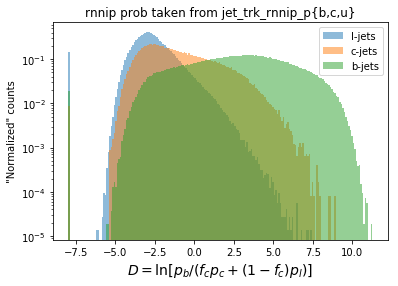

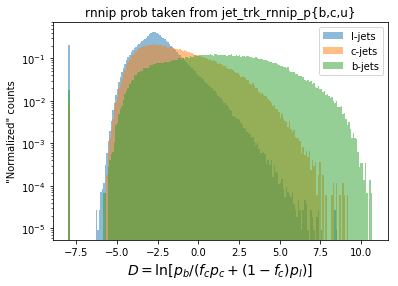

In [34]:
# Save the efficiencies from the previous training in a separate list
Zihao_leffs, Zihao_ceffs, Zihao_beffs, Zihao_discs = [], [], [], []
fc = 0.07
nBins = 200

for physicsSample, nTrks in zip(['ttbar','Zprime_1.5TeV'],[15,25]):
    
    plt.figure()
        
    # Open the df
    dataDir = '../../data/mc16d_{}_{}'.format(jetCollection,physicsSample)
    df_tag = '2mtest_15trks_sd0_rev'
    jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

#     jet_df['disc'] = -8
#     m = ()
    disc = np.log(jet_df.rnnip_pb / (fc*jet_df.rnnip_pc + (1-fc)*jet_df.rnnip_pu))
    disc[jet_df.ip3d_ntrk == 0] = -8
    
    myRange = (disc.min(),disc.max())
    
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        n,_,_ = plt.hist(disc[jet_df.LabDr_HadF == pdg],
                         bins=nBins,range=myRange, 
                         label="{}-jets".format(flav),
                         alpha = 0.5,
                         density=True, log=True) 

        # Calculate the eff
        eff = calculateEff(n)

        if pdg == 0:
            Zihao_leffs.append(eff)
        elif pdg == 4:
            Zihao_ceffs.append(eff)
        elif pdg == 5:
            Zihao_beffs.append(eff)

    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('"Normalized" counts')
    plt.title("rnnip prob taken from jet_trk_rnnip_p{b,c,u}")
    plt.show()

Evaluating on ttbar
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


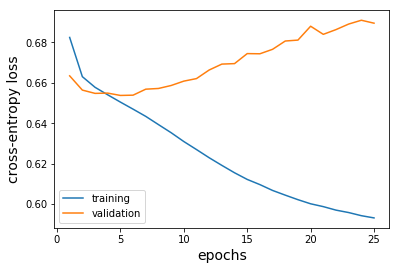

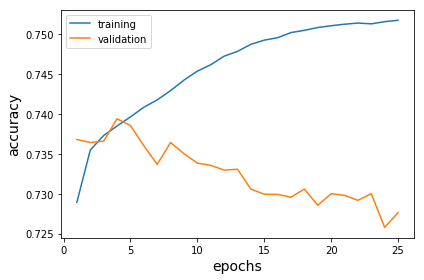

min: -12.87, max: 12.85


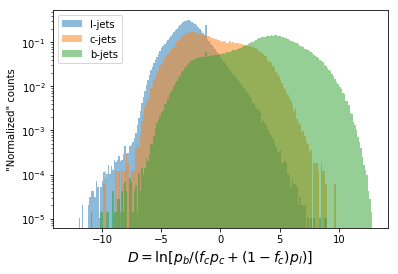

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


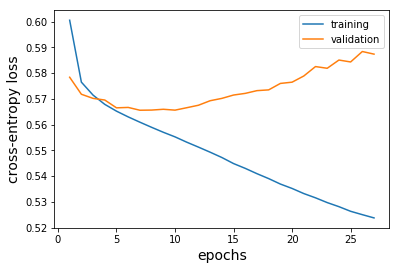

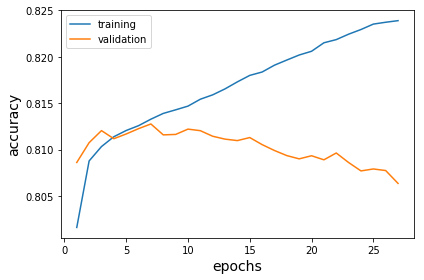

min: -6.88, max: 12.40


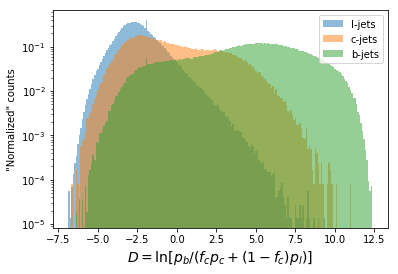

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


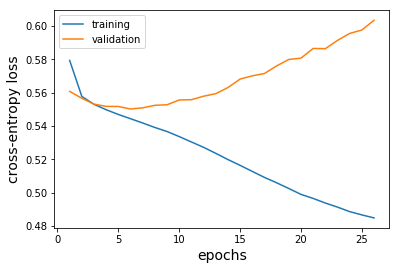

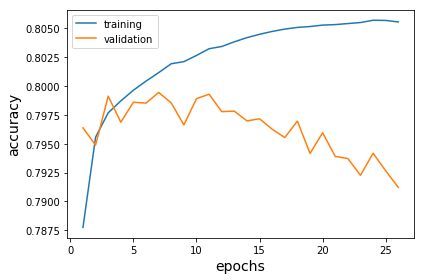

min: -8.09, max: 10.71


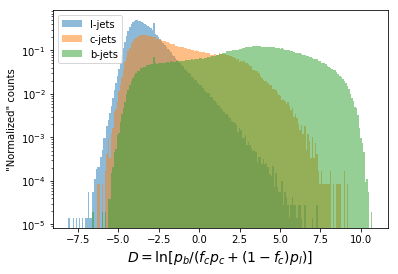

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


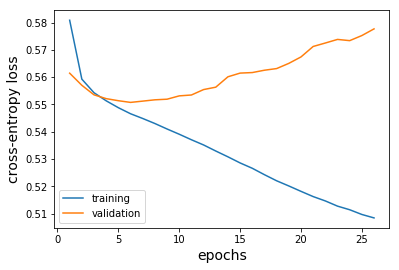

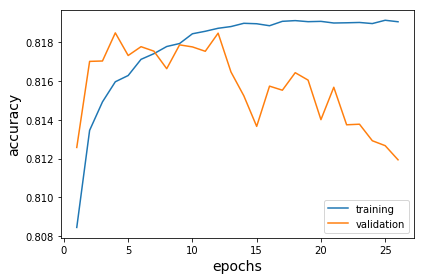

min: -10.42, max: 11.32


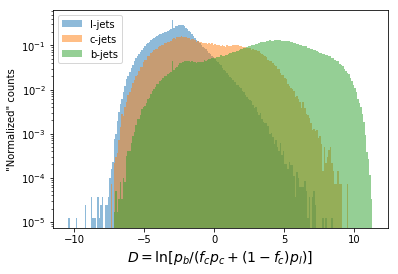

Evaluating on Zprime_1.5TeV
Initialize method from myModel()
Loading previously trained LSTM
min: -11.80, max: 13.48


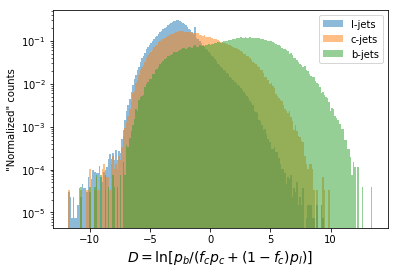

Initialize method from myModel()
Loading previously trained LSTM
min: -7.23, max: 12.23


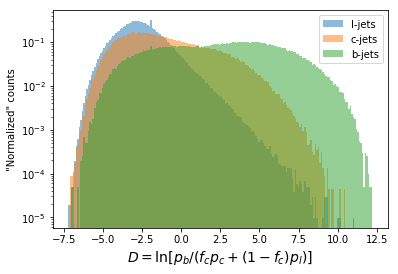

Initialize method from myModel()
Loading previously trained LSTM
min: -7.41, max: 10.25


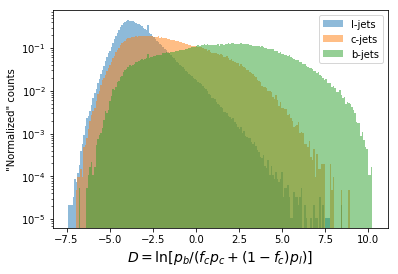

Initialize method from myModel()
Loading previously trained LSTM
min: -9.70, max: 11.23


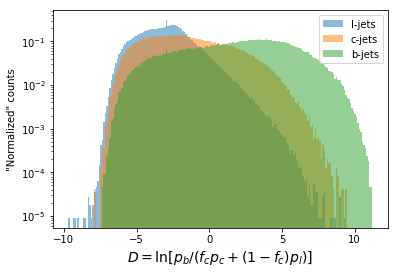

In [29]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, Ntest, nTrks_te in zip(['ttbar','Zprime_1.5TeV'],[int(1.5e6)]*2,[15,25]):
        
    print('Evaluating on '+physicsSample)
        
    for trJetCol, trainPhysicsSample, Ntrain, nHidden, nTrks_tr in \
        zip(['PFlow']+['VR']*3, ['hybrid_5TeV','ttbar','Zprime_1.5TeV','hybrid_1.5TeV'],
            [int(5e6),int(2e6),int(3e6),int(4e6)], [400]+[200]*3, [15,15,25,15]):
        
        # Load in the sample for evaluation
        subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
        if trJetCol != jetCollection:
            scale_tag = '_' + trJetCol + scale_tag

        dataTagTest = "2mtest_{}trks_{}_sd0_rev{}".format(nTrks_te,vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        # If we're evaluating the model that has been trained on 
        nTest = X.shape[0]
        if nTrks_te > nTrks_tr:
            # Restrict the # of tracks you're evaluating with
            X = X[:,:nTrks_tr,:]
        if nTrks_te < nTrks_tr:
            # Append 0s
            zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
            X = np.concatenate((X,zeros),axis=1)

        # Also open the df so that you'll have access to the jet pt and eta
        jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

        # Load in the model
        modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

        # Training metrics
        if physicsSample == 'ttbar':
            trainingMetrics(m.modelName,modelDir=modelDir)

        # Get the efficiencies
        tag = '_eval_{}_pt_10GeV'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        (leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                          figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

        ys.append(y)
        pts.append(jet_df.pt.values)
        etas.append(jet_df.eta.values)



## $t\bar{t}$ evaluation

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


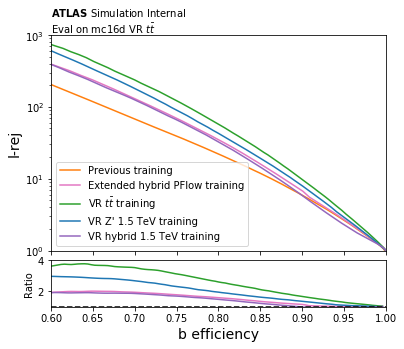

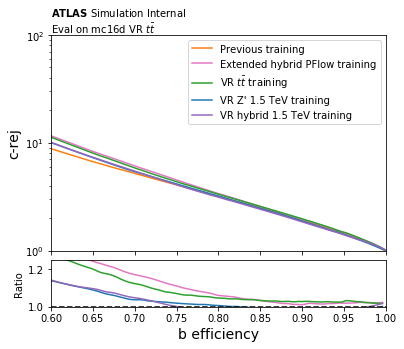

In [59]:
train_labels = ['Previous training','Extended hybrid PFlow training']
train_labels+=['VR {} training'.format(x) for x in [r'$t\bar{t}$','Z\' 1.5 TeV','hybrid 1.5 TeV']]

ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_ttbar'
plotTag = 'rej_cf_pflow'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['C1','C6','C2','C0','C4']

plotROCRatio([Zihao_beffs[0]]+beffs[:4], [Zihao_leffs[0]]+leffs[:4], 
             train_labels, rrange=(1,4),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio([Zihao_beffs[0]]+beffs[:4], [Zihao_ceffs[0]]+ceffs[:4], 
             train_labels, rrange=(1,1.25),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

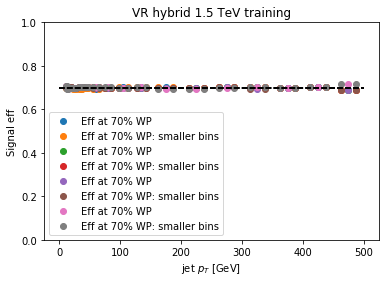

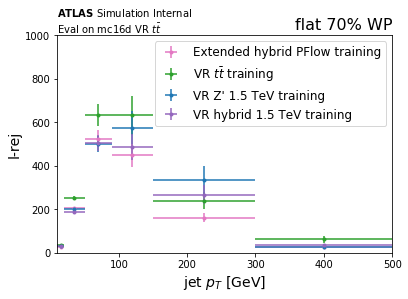

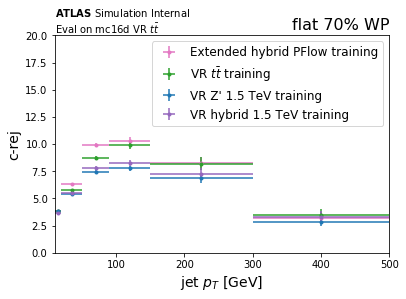

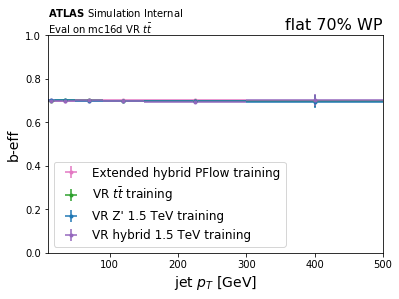

In [60]:
plotPtDependence(pts[0],ys[0],discs[:4], train_labels[1:],
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1), verbose=False,
                 flat=True,binomialErrors=True,colors=colors[1:],text=text,
                 pt_edges=np.array([10,20, 50, 90, 150, 300, 500]),
                 eff_bins = np.array([10,12.5,15,17.5,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500]),
                 figDir=figDir,subDir=subDir,tag=plotTag)

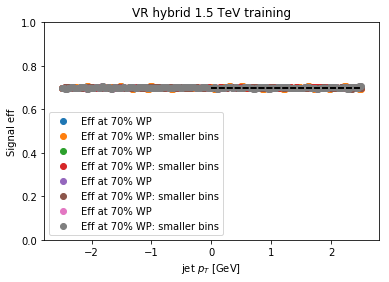

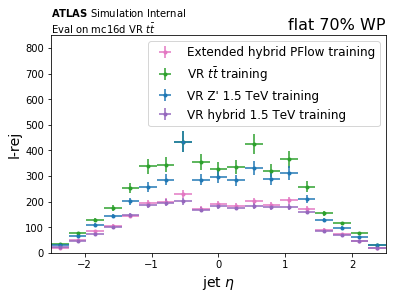

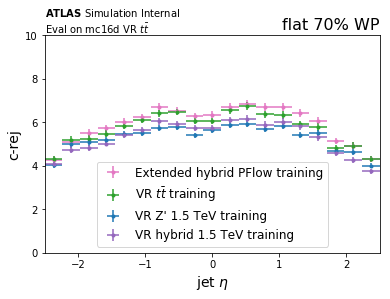

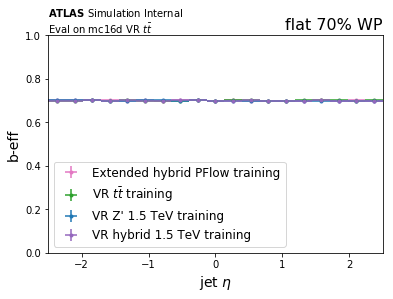

In [61]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[0],ys[0],discs[:4], train_labels[1:], xlabel='jet $\eta$',
                 lrej_lim=(0,850),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors[1:],text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),verbose=False,
                 figDir=figDir,subDir=subDir,tag=plotTag,
                 var='eta')

## Z' evaluation

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)


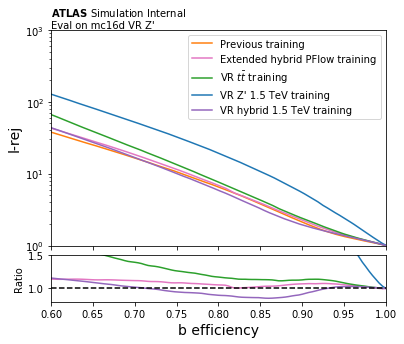

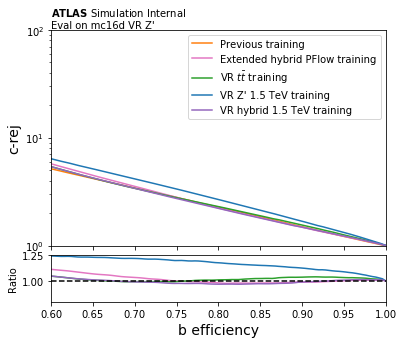

In [62]:
ntests = [np.sum(ys[4]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_1.5TeV'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z'"

plotROCRatio([Zihao_beffs[1]]+beffs[4:], [Zihao_leffs[1]]+leffs[4:], 
             train_labels, rrange=(0.8,1.5),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio([Zihao_beffs[1]]+beffs[4:], [Zihao_ceffs[1]]+ceffs[4:], 
             train_labels, rrange=(0.8,1.25),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

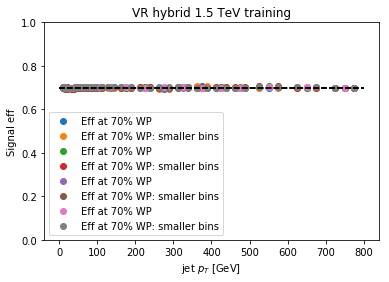

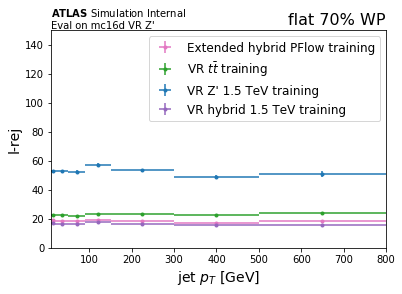

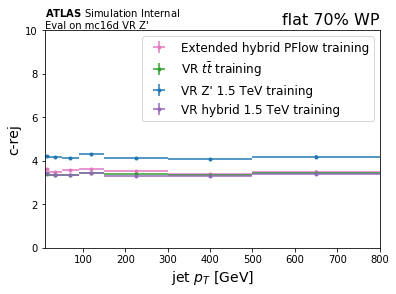

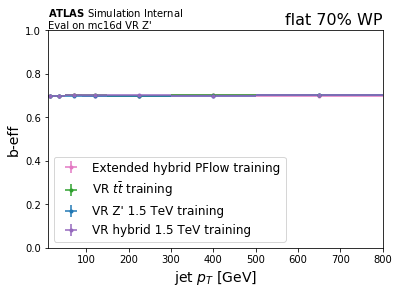

In [63]:
plotPtDependence(pts[4],ys[4],discs[4:], train_labels[1:],
                 lrej_lim=(0,150),crej_lim=(0,10),beff_lim=(0,1), verbose=False,
                 flat=True,binomialErrors=True,colors=colors[1:],text=text,
                 pt_edges=np.array([10,20, 50, 90, 150, 300, 500,800]),
                 eff_bins = np.array([10,12.5,15,17.5,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,600,700,800]),
                 figDir=figDir,subDir=subDir,tag=plotTag)

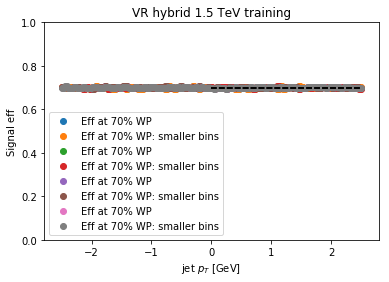

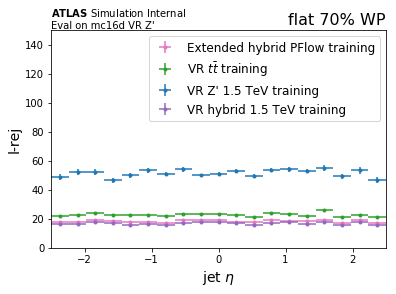

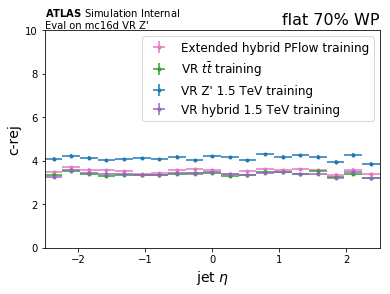

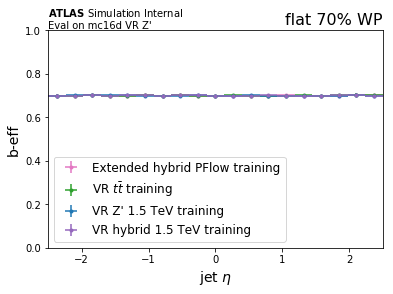

In [64]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[4],ys[4],discs[4:], train_labels[1:], xlabel='jet $\eta$',
                 lrej_lim=(0,150),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors[1:],text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),verbose=False,
                 figDir=figDir,subDir=subDir,tag=plotTag, var='eta')